# Q-Learning

In [1]:
import numpy as np
import pandas as pd
import random

### Define States ###
states = []
for i in range(14):
    for j in range(20):
        states.append((i+1, j+1))

# Left wall states
left_wall = []
for i in range(16):
    left_wall.append((i, 0))
# Upper wall states
upper_wall = []
for j in range(22):
    upper_wall.append((15, j))
# Right wall
right_wall = []
for i in range(16):
    left_wall.append((i, 21))
# Bottom wall
bottom_wall = []
for j in range(22):
    upper_wall.append((0, j))

# Concat to walls
walls = left_wall + upper_wall + right_wall + bottom_wall

# Vertical wall + tree (right from Trainer)
for i in range(4, 14+1):
	walls.append((i, 4))

# Horizontal trees + building + mountain
for i in range(9, 16):
    for j in range(4, 20+1):
	    walls.append((i, j))
walls.remove((9,8)) # Do not add door to walls

# Horizontal lower wall 
for j in range(4, 16+1):
	walls.append((4, j))
walls.remove((4,8)) # Do not add staircase to walls

# Vertial Call right from charmander
for i in range(3, 9+1):
	walls.append((i, 19)) 
    
# Vertical Wall left from charmander
walls.append((8, 12))
walls.append((7, 12))
for j in range(12, 20):
    walls.append((6, j))
walls.remove((6, 16))

# Some tress at the bottom
tree = [(4, 14), (3, 14), (2, 14), (1, 14), (0, 14), (4, 15), (3, 15), (2, 15), (1, 15), (0, 15)]
walls.extend(tree)


### Define Rewards ###
rewards = {}
for state in states:
    # Catch Charmander
    if state == (8, 18):
        rewards[state] = 100
    # For all other States
    else:
        rewards[state] = -0.5
    

# Function that returns the valid next state, given action and current state
def getNextState(a: str, s: tuple) -> tuple:
    if a == "U":
        next_state = (s[0] + 1, s[1])
        if next_state in walls:
            next_state = (s[0], s[1])

    if a == "D":
        next_state = (s[0] - 1, s[1])
        if next_state in walls:
            next_state = (s[0], s[1])    

    if a == "L":
        next_state = (s[0], s[1] - 1)
        if next_state in walls:
            next_state = (s[0], s[1])

    if a == "R":
        next_state = (s[0], s[1] + 1)
        if next_state in walls:
            next_state = (s[0], s[1])
    
    return next_state


### Define Action Space for each State ###
actions = {}
for s in states:
    temp_action = []

    if getNextState("U", s) != s:
        temp_action.append("U")

    if getNextState("D", s) != s:
        temp_action.append("D")

    if getNextState("L", s) != s:
        temp_action.append("L")

    if getNextState("R", s) != s:
        temp_action.append("R")

    actions[s] = temp_action


################################################
### Define Q-Table and initialize it with 0  ###
################################################
n_states = len(states)      
n_action = 4

# Initialize Q_Table to all Zeros and convert to pd DataFrame
Q = np.zeros(shape=(n_states, n_action))
Q = pd.DataFrame(Q, columns=["U", "D", "L", "R"], index=states)

print("Q-Table at the beginning:")
display(Q)

### Define Hyperparams ###
GAMMA = 0.9
EPSILON = 0.9
ALPHA = 0.75
EPISODE = 1500

records = pd.DataFrame()
reward_history = []

# Q-Learning algorithm:
for i in range(EPISODE):
    # Add Reward History to our Records DataFrame for Analysis
    if i != 0: 
        records[f"Episode {i-1}"] = pd.Series(reward_history)
    reward_history.clear()

    # Init (a, b) to (1, 4) so that the while loop always triggers and shuffles new
    (a, b) = (0, 0)

    # Get random start state
    while (a, b) in walls:
        a = np.random.choice(a=np.arange(15))
        b = np.random.choice(a=np.arange(21))

    state = (a, b)

    if i % 100 == 0: print(f"Start State at Epsiode {i} is {state}")
    
    # Simulate Swipes
    for i in range(100):
        #print(f"Current state: {state}")
        
        # Get next state randomly (Exploration)
        # Epsilon decreases in relation to the current episode
        # Thus Epsilon is high at the beginning and low at the end
        if random.random() < round(EPSILON**i**(1/2), 4):
            # Get random action
            a = np.random.choice([action for action in actions[state]])
            next_state = getNextState(a, state)
            #print(f"Random Action '{a}' has been taken. Resulting next state is {next_state}")

        # Get next state from Q-Table (Exploitation)
        else:
            valid_actions = [action for action in actions[state]]
            #print(f"Valid Action in state {state} is: {valid_actions}")
            # Get max_a q(state, a) from the Q-Table
            a = list(Q.loc[[state], [action for action in actions[state]]].idxmax(axis=1).values)[0]
            #print(f"Max Action in state {state} is: {a}")
            next_state = getNextState(a, state)
            #print(f"Next state is: {next_state}")

        # Update Q-Table
        Q.at[state, a] = Q.at[state, a] + ALPHA * (rewards[next_state] + GAMMA * float(Q.loc[[next_state], :].max(axis=1)) - Q.at[state, a])
        reward_history.append(rewards[next_state])
                
        # If we reach one terminal state: end swiping and continue with next episode
        if next_state == (8, 18):
            break
        
        state = next_state
    
    
print("Training is finished!")
print("Q-Table in the end:")
display(Q)


Q-Table at the beginning:


,U,D,L,R
"(1, 1)",0.0,0.0,0.0,0.0
"(1, 2)",0.0,0.0,0.0,0.0
"(1, 3)",0.0,0.0,0.0,0.0
"(1, 4)",0.0,0.0,0.0,0.0
"(1, 5)",0.0,0.0,0.0,0.0
...,...,...,...,...
"(14, 16)",0.0,0.0,0.0,0.0
"(14, 17)",0.0,0.0,0.0,0.0
"(14, 18)",0.0,0.0,0.0,0.0
"(14, 19)",0.0,0.0,0.0,0.0


Start State at Epsiode 0 is (6, 1)
Start State at Epsiode 100 is (7, 1)
Start State at Epsiode 200 is (1, 18)
Start State at Epsiode 300 is (6, 1)
Start State at Epsiode 400 is (1, 2)
Start State at Epsiode 500 is (8, 8)
Start State at Epsiode 600 is (6, 11)
Start State at Epsiode 700 is (2, 19)
Start State at Epsiode 800 is (11, 1)
Start State at Epsiode 900 is (13, 1)
Start State at Epsiode 1000 is (5, 18)
Start State at Epsiode 1100 is (7, 15)
Start State at Epsiode 1200 is (4, 1)
Start State at Epsiode 1300 is (1, 18)
Start State at Epsiode 1400 is (8, 14)
Training is finished!
Q-Table in the end:


,U,D,L,R
"(1, 1)",36.944446,0.0,0.000000,37.103197
"(1, 2)",41.782532,0.0,32.879602,41.790920
"(1, 3)",46.990263,0.0,37.060148,47.068678
"(1, 4)",53.152404,0.0,41.766824,52.933551
"(1, 5)",59.833774,0.0,46.813694,59.627213
...,...,...,...,...
"(14, 16)",0.000000,0.0,0.000000,0.000000
"(14, 17)",0.000000,0.0,0.000000,0.000000
"(14, 18)",0.000000,0.0,0.000000,0.000000
"(14, 19)",0.000000,0.0,0.000000,0.000000


# Print optimal Policy 🚀


In [2]:
# Function to print the optimal policy for each state
def printBestActionForEachState():
    # Print optimal policy 
    for state in states:
        # Skip terminal states and wall
        if state in walls:
            pass
        # All other non-terminal states 
        else:
            best_action = list(Q.loc[[state], :].idxmax(axis=1).values)[0]
            print(f"The best action in state {state} is {best_action}")

rewards_hist = []
# Recursive function to draw path beginning at s (should be s = (14, 2))
def printPath(s):
    if s == (8, 18):
        print(s)
        print("Terminal state has been reached.")
        return 
    # Get best action from Q-Table and call function with next state
    print(s)
    best_action = str(list(Q.loc[[s], :].idxmax(axis=1).values)[0])
    next_state = getNextState(best_action, s)
    # Add reward of the transition into the record list
    rewards_hist.append(rewards[next_state])
    printPath(next_state)

# Define start state and output optimal path
START_STATE = (14, 2)
printPath(START_STATE)

print(f"Total Reward collected: {sum(rewards_hist)}")


(14, 2)
(13, 2)
(13, 3)
(12, 3)
(11, 3)
(10, 3)
(9, 3)
(8, 3)
(7, 3)
(6, 3)
(5, 3)
(4, 3)
(3, 3)
(3, 4)
(3, 5)
(3, 6)
(3, 7)
(3, 8)
(4, 8)
(5, 8)
(5, 9)
(5, 10)
(5, 11)
(5, 12)
(5, 13)
(5, 14)
(5, 15)
(5, 16)
(6, 16)
(7, 16)
(8, 16)
(8, 17)
(8, 18)
Terminal state has been reached.
Total Reward collected: 84.5


# Plot sum of rewards in each episode 🥇

Text(0, 0.5, 'Reward')

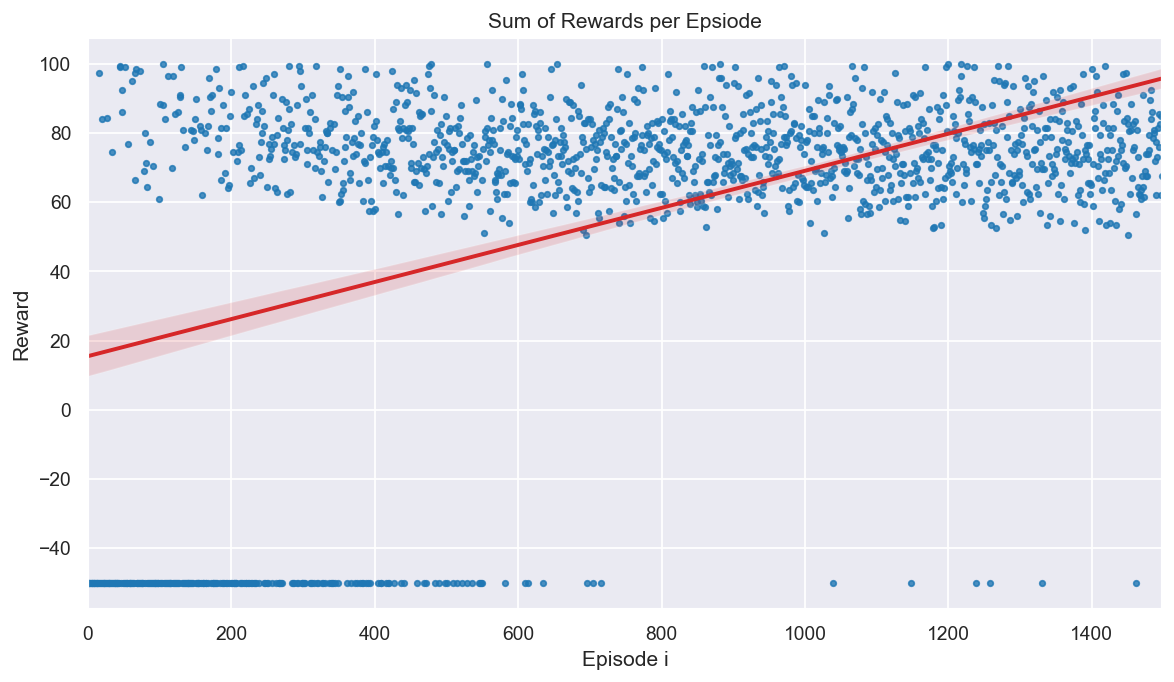

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

reward_per_episode = []
# Calculate for each Episode the sum of rewards and append it to list
for i in np.arange(0, len(records.columns)):
    col_of_int = records.iloc[:, i]
    n_of_col = col_of_int.count()
    reward_per_episode.append(col_of_int.sum())

# Plot Settings
plt.figure(figsize=(11,6), dpi=126)
sns.regplot(x=np.arange(0, len(reward_per_episode)), y=reward_per_episode, scatter_kws={"color": "tab:blue", "s": 10}, line_kws={"color": "tab:red"})
plt.title("Sum of Rewards per Epsiode")
plt.xlabel("Episode i")
plt.ylabel("Reward")